# Part A - Generate Dataset

### Objective:
    1) Build dataset for training a font classification model for following fonts (classes)-         
        - Oswald
        - Roboto
        - OpenSans
        - Ubuntu
        - PTSerif
        - DancingScript
        - FredokaOne
        - Arimo
        - NotoSans
        - PatuaOne
    
### Characterstics of the dataset:
    1) All image have the term "Hello, World!"
    2) All images are black text on white background
    
### Approach:
    1) Generate empty boards - Understand characterstics from sample images
        - Range of image height (ranges from 111 to 567)
        - Range of image weight (ranges from 91 to 193)
       
    2) Add text to empty boards at random locations with random scale and opacity
    
    3) Image agumentation (To generate larger training data for better generalisation)
        - Image Rotation (ranges from -30 to 30 degrees)
        - Image Blur (Kernel size from (2 to 8)
        - Adding watermark
        
        Note: These are intutively selected based on what users can share as specimen
    
### Generated dataset size:
    1) Total random boards = 10
    2) Total fonts (including all fonts types from family) = 42 
    3) Total random texts additions = 3 per boards
    4) Total agumentated images = 3 per original generated text image
    
    Final images: 10 * 42 * 3 = 1260
    Final augumented images = 1260 * 3 = 3870

In [1]:
import os
import cv2
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

## Step 1 - Estimate image characterstics from sample

In [2]:
loaded_sample_images = []
for im_path in os.listdir('sample_images'):
    loaded_sample_images.append(cv2.imread('sample_images/{}'.format(im_path)).shape)

In [3]:
loaded_sample_images = pd.DataFrame(loaded_sample_images).rename(columns={
    0: 'Height of sample',
    1: 'Width of sample',
    2: 'Number of channels'
})
loaded_sample_images['ratio'] = loaded_sample_images['Width of sample']/ loaded_sample_images['Height of sample']
loaded_sample_images

,Height of sample,Width of sample,Number of channels,ratio
0,106,273,3,2.575472
1,91,252,3,2.769231
2,121,237,3,1.958678
3,93,229,3,2.462366
4,125,247,3,1.976000
5,112,243,3,2.169643
6,94,330,3,3.510638
7,132,567,3,4.295455
8,182,321,3,1.763736
9,193,450,3,2.331606


In [4]:
loaded_sample_images.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Height of sample,10.0,124.900000,35.914868,91.000000,97.000000,116.500000,130.250000,193.000000
Width of sample,10.0,314.900000,111.060994,229.000000,244.000000,262.500000,327.750000,567.000000
Number of channels,10.0,3.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
ratio,10.0,2.581282,0.782145,1.763736,2.024411,2.396986,2.720791,4.295455


## Step 2 - Generate images with random text characterstics

In [5]:
def get_random_white_image():
    """
    
    Get image with white background
     - Randomly generated
     - Height and weight estimated from sample images
    """
    
    image_height = random.randrange(
        loaded_sample_images['Height of sample'].min(), 
        loaded_sample_images['Height of sample'].max()
    )
    
    hw_ration = random.uniform(
        loaded_sample_images['ratio'].min(), 
        loaded_sample_images['ratio'].max()
    )
    image_width = int(image_height * hw_ration)

    img = np.ones((image_height, image_width, 3), np.uint8)
    img.fill(255)
    
    return img, image_height, image_width


def add_text_to_image(pil_img, path_to_font, text="Hello, World!", opacity=None):
    """
    
    Add text to the given image.
     - The top left coordinates are randomly projected on initial 40% of height and 20% of weight
     - Opacity is randomly selected from (150 to 255)
     - Text scale is randomly selected from (30 to 50)
    param pil_img: Image vector loaded in PIL
    param path_to_font: Path to the font to be used for drawing
    param text: Text to be used for drawing (default: "Hello, World!")
    param opacity: Opacity of the text (Default: If None, randomly selected)
    
    returns output image with text drawn
    """
    
    # Estimate parameters
    coordinate_upper_left_height = int(random.uniform(0, 0.4) * pil_img.size[1])
    coordinate_upper_left_width = int(random.uniform(0, 0.2) * pil_img.size[0])
    
    text_scale = random.randrange(30, 50)
    
    if opacity is None:
        opacity = random.randrange(150, 255)
    
    # Draw on the image using PIL
    text_image = Image.new("RGBA", pil_img.size, (255, 255, 255, 0))
    font = ImageFont.truetype(path_to_font, text_scale)

    draw = ImageDraw.Draw(text_image)    
    draw.text(
        (coordinate_upper_left_width,coordinate_upper_left_height), 
        text, 
        font=font, 
        fill=(0, 0, 0, opacity)
    )
    
    out = Image.alpha_composite(pil_img, text_image)
    
    return out


def rotate_image(mat, angle):
    """
    
    Rotates an image (angle in degrees) and expands image to avoid cropping
    Used code from: https://stackoverflow.com/questions/43892506/opencv-python-rotate-image-without-cropping-sides/47248339
    """

    height, width = mat.shape[:2]
    
    # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(255,255,255))
    return rotated_mat

Raw Image Board:


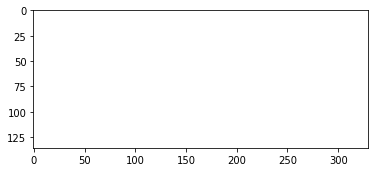

Added Text:


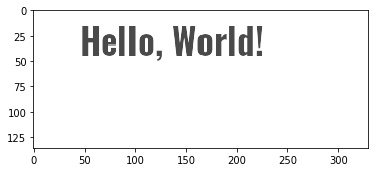

Added Rotation:


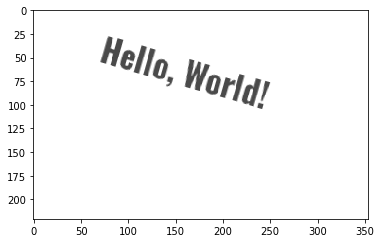

Added Blur:


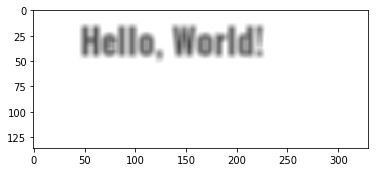

Added Watermark:


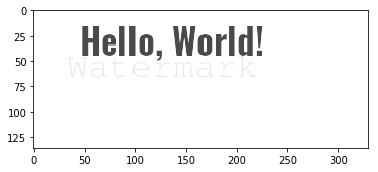

CPU times: user 1.06 s, sys: 382 ms, total: 1.44 s
Wall time: 507 ms


In [6]:
%%time

def test_pipeline():
    """
    
    Test pipeline to verfiy before generating large number of images
    Randomly generated image and its transformations are displayed on the notebook
    """
    
    print ("Raw Image Board:")
    
    raw_image, image_height, image_width = get_random_white_image()
    
    imgplot = plt.imshow(raw_image)
    plt.show()

    print ("Added Text:")
    
    cv2.imwrite('test_image.png', raw_image)
    base_pil_image = Image.open('test_image.png').convert("RGBA")
    path_to_font = "fonts/Oswald-Bold.ttf"
    text_added_image = add_text_to_image(base_pil_image, path_to_font, text="Hello, World!")
    text_added_image.save('test_image.png') 
    
    imgplot = plt.imshow(text_added_image)
    plt.show()

    text_added_image = cv2.imread('test_image.png'.format(1))

    # Image Augumentation: Rotation
    print ("Added Rotation:")
    angle = random.randrange(-45, 45)
    rotated_text_added_image = rotate_image(text_added_image, angle)

    imgplot = plt.imshow(rotated_text_added_image)
    plt.show()

    # Image Augumentation: Blur
    print ("Added Blur:")
    kernel_size = random.randrange(2, 8)
    blur = cv2.blur(text_added_image, (kernel_size, kernel_size))

    imgplot = plt.imshow(blur)
    plt.show()

    # Image Augumentation: Add Watermark
    print ("Added Watermark:")
    base_pil_image = Image.open('test_image.png'.format(1)).convert("RGBA")
    path_to_font = "Pillow/Tests/fonts/FreeMono.ttf"
    watermark_added_image = add_text_to_image(base_pil_image, path_to_font, text="Watermark", opacity=25)

    imgplot = plt.imshow(watermark_added_image)
    plt.show()
    
test_pipeline()

In [7]:
def pipeline_generate_images_with_text(text='Hello, World!', number_of_boards=10, number_of_iterations=3):
    """
    
    Generated images with given text of random characterstics
    param text: Text to draw on the image
    param number_of_boards: number of random boards to generate
    param number_of_iterations: number of iterations to draw with random characterstics
    return: Save raw boards and text images inside data directory
    """
    
    # Make directory if not existing already
    os.makedirs('data/generated_boards',  exist_ok=True)
    os.makedirs('data/generated_text_images',  exist_ok=True)

    print ("Generating images with different text properties for '{}'...".format(text))
    for i in range(number_of_boards):
        
        # Generate random white board
        raw_image, image_height, image_width = get_random_white_image()
        board_path = 'data/generated_boards/{}_{}.png'.format(i, text.replace(' ', '-'))         
        cv2.imwrite(board_path, raw_image)

        base_pil_image = Image.open(board_path).convert("RGBA")

        # Iterate to draw for all fonts
        for font in os.listdir('fonts'):
            path_to_font = 'fonts/{}'.format(font)

            # Generate random iterations for each font and each raw board
            for iteration in range(number_of_iterations):
                text_added_image = add_text_to_image(
                    base_pil_image, 
                    path_to_font, 
                    text=text
                )
                save_filepath = 'data/generated_text_images/{}_{}_{}.png'.format(
                    board_path.split('/')[-1].split('.png')[0], 
                    font.replace('_', '-').split('.ttf')[0],
                    iteration
                )
                text_added_image.save(save_filepath)

In [8]:
%%time

# Generate text images with different characterstics for "Hello, World!" both in lower and upper case
pipeline_generate_images_with_text('Hello, World!', number_of_boards=10)
pipeline_generate_images_with_text('HELLO, WORLD!', number_of_boards=10)

Generating images with different text properties for 'Hello, World!'...
Generating images with different text properties for 'HELLO, WORLD!'...
CPU times: user 12.1 s, sys: 351 ms, total: 12.5 s
Wall time: 12.3 s


In [9]:
%%time

# Generate text images with different characterstics for different text
# Purpose is to test for generalisation and have more training data (if required)

pipeline_generate_images_with_text('Co-Founder & CEO', number_of_boards=5)
pipeline_generate_images_with_text('Design Lead', number_of_boards=5)

Generating images with different text properties for 'Co-Founder & CEO'...
Generating images with different text properties for 'Design Lead'...
CPU times: user 7.04 s, sys: 120 ms, total: 7.16 s
Wall time: 7.16 s


## Step 3 - Generate transformed images from originally generated text images

In [10]:
def pipeline_generate_augumented_images(path_to_text_images='data/generated_text_images'):
    """
    
    For each of the raw text image generated add transformed images
    param path_to_text_images: path where all text images are stored
    """
    
    # Make directory if not existing already
    os.makedirs('data/generated_rotated',  exist_ok=True)
    os.makedirs('data/generated_blur',  exist_ok=True)
    os.makedirs('data/generated_watermark',  exist_ok=True)

    for img_name in os.listdir(path_to_text_images):
        text_added_image = cv2.imread('{}/{}'.format(path_to_text_images, img_name))
        text_added_image_pil = Image.open('{}/{}'.format(path_to_text_images, img_name)).convert("RGBA")

        # Add rotated image
        for iteration in range(1):
            angle = random.randrange(-45, 45)
            rotated_text_added_image = rotate_image(text_added_image, angle)

            save_filepath = 'data/generated_rotated/{}_rotated_{}.png'.format(img_name.split('.png')[0], iteration)
            cv2.imwrite(save_filepath, rotated_text_added_image)

        # Add blurred image        
        for iteration in range(1):
            kernel_size = random.randrange(2, 8)
            blur = cv2.blur(text_added_image, (kernel_size, kernel_size))

            save_filepath = 'data/generated_blur/{}_blur_{}.png'.format(img_name.split('.png')[0], iteration)
            cv2.imwrite(save_filepath, blur)

        # Add watermark to the image (User may share a watermarked sample to copy font)
        for iteration in range(1):
            watermark_added_image = add_text_to_image(
                text_added_image_pil, 
                path_to_font="Pillow/Tests/fonts/FreeMono.ttf", 
                text="Watermark", 
                opacity=25)

            save_filepath = 'data/generated_watermark/{}_watermark_{}.png'.format(img_name.split('.png')[0], iteration)
            watermark_added_image.save(save_filepath) 

In [11]:
%%time

# Generated image transformations (In case more training data is required)

pipeline_generate_augumented_images()

CPU times: user 48 s, sys: 3.23 s, total: 51.3 s
Wall time: 46.5 s
